# Exploring the Billboard Hot 100
Since August 4th 1958, Billboard magazine has released a weekly record chart that ranks the popularity of the top 100 songs across all genres: the Billboard Hot 100.    The Hot 100 began as an all genre singles chart but the songs eligible for inclusion on the Billboard Hot 100 and the metrics used to determine a song's popularity expanded as the music industry evolved.  Today, chart rankings are based on physical and digital sales, radio play, and online streaming in the United States.  In this notebook, I explore the chart data over the past 60 years, analyzing correlations and trends and creating some visualizations.

Note: Please view the notebook at this [link](https://nbviewer.jupyter.org/github/mgthometz/Billboard-Hot100/blob/master/Hot%20100%20Data%20Analysis.ipynb) to ensure that the Bokeh plots render.

In [1]:
#Load Packages
from bokeh.io import output_notebook
from bokeh.layouts import column, widgetbox, row, gridplot
from bokeh.models import ColumnDataSource, Select,Range1d, TapTool, HoverTool, FactorRange
from bokeh.plotting import figure,show
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
output_notebook()

Loading BokehJS ...

## Data Cleaning
Chart data was scraped from the Billboard website using the unofficial Billboard API available at https://github.com/guoguo12/billboard-charts.  The data set contains all chart data from the first Hot 100 chart released on August 4th, 1958 to the chart released on August 4th, 2018.  

In [2]:
#Load Data
billboard_songs1=pd.read_pickle('billboard_songs1.pkl')
billboard_songs2=pd.read_pickle('billboard_songs2.pkl')
billboard_songs=pd.concat([billboard_songs1,billboard_songs2])
billboard_songs.reset_index(inplace=True,drop=True)
billboard_songs.sort_values(by=['song_id','Date'],inplace=True)
billboard_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313200 entries, 147583 to 310946
Data columns (total 10 columns):
Artist        313200 non-null object
CurrentPos    313200 non-null int64
Date          313200 non-null datetime64[ns]
LastPos       313200 non-null int64
PeakPos       313200 non-null int64
Title         313200 non-null object
Weeks         313200 non-null int64
Year          313200 non-null int64
isNew         313200 non-null bool
song_id       313200 non-null object
dtypes: bool(1), datetime64[ns](1), int64(5), object(3)
memory usage: 24.2+ MB


Descriptions of the columns: <br><br>
Artist - The name of the artist <br>
CurrentPos - The current position of the song on the chart <br>
Date -  The chart date <br>
LastPos - The song's position on the previous week's chart.  If the song was not on the previous week's chart this               value is zero <br>
PeakPos - The song's peak position on the chart, up to and including the current chart date<br>
Title - The title of the song <br>
Weeks - The number of weeks the song has been on the Hot 100, up to and including the current chart date <br>
Year - The year of the chart date, created to make exploring trends over time  easier <br>
isNew - Whether the song is new to the Hot 100 <br>
song_id - The song title and artist, created to remove the ambiguity of different songs with the same title<br>


To gain a better understanding of the data set and check for any irregularities, let's focus on chart data for one of the most successful Hot 100 artist of all time, The Beatles.

In [3]:
billboard_songs[billboard_songs['Artist']=='The Beatles'].head(10)

,Artist,CurrentPos,Date,LastPos,PeakPos,Title,Weeks,Year,isNew,song_id
278980,The Beatles,81,1965-02-27,0,81,4 - By The Beatles,0,1965,True,4 - By The Beatles The Beatles
278876,The Beatles,77,1965-03-06,81,77,4 - By The Beatles,2,1965,False,4 - By The Beatles The Beatles
278772,The Beatles,73,1965-03-13,77,73,4 - By The Beatles,3,1965,False,4 - By The Beatles The Beatles
278669,The Beatles,70,1965-03-20,73,70,4 - By The Beatles,4,1965,False,4 - By The Beatles The Beatles
278567,The Beatles,68,1965-03-27,70,68,4 - By The Beatles,5,1965,False,4 - By The Beatles The Beatles
282120,The Beatles,21,1964-07-18,0,21,A Hard Day's Night,0,1964,True,A Hard Day's Night The Beatles
282001,The Beatles,2,1964-07-25,21,2,A Hard Day's Night,2,1964,False,A Hard Day's Night The Beatles
281900,The Beatles,1,1964-08-01,2,1,A Hard Day's Night,3,1964,False,A Hard Day's Night The Beatles
281800,The Beatles,1,1964-08-08,1,1,A Hard Day's Night,4,1964,False,A Hard Day's Night The Beatles
281702,The Beatles,3,1964-08-15,1,1,A Hard Day's Night,5,1964,False,A Hard Day's Night The Beatles


A quick inspection of the rows for the song "A Hard Day's Night" indicates that the Weeks column for the song's debut onto the chart has a value of 0, while the Weeks column for the following week has a value of 2.  This suggests that when a song debuts onto the chart, the corresponding Weeks value is recorded as 0 instead of the expected, more logical value of 1. Since this inconsistency can skew statistics for the Weeks column, this issue definitely warrants further investigation.


In [4]:
print('Number of chart entries with a Weeks value of 0: ',len(billboard_songs[billboard_songs['Weeks']==0]))
print('Number of chart entries with a Weeks value of 1: ',len(billboard_songs[billboard_songs['Weeks']==1]))
print('Number of chart entries with a Weeks value of 2: ',len(billboard_songs[billboard_songs['Weeks']==2]))


Number of chart entries with a Weeks value of 0:  27673
Number of chart entries with a Weeks value of 1:  35
Number of chart entries with a Weeks value of 2:  25870


Clearly, there seems to be some irregularities in the data scraped from the Billboard website.  However, before making any changes to the data set, let's first take a look at the number of unique songs in the dataset, the number of songs marked as new in the dataset, and the number of unique songs marked as new in the dataset.  In theory, all of these numbers should be equal since the data set starts with the first Hot 100 chart ever released, and every song must have debuted at some point.

In [5]:
debut_songs=billboard_songs[billboard_songs['isNew']==True]
print('Number of unique songs on the Billboard Hot 100:', len(set(billboard_songs['song_id'])))
print('Number of songs labeled as new on the Billboard Hot 100: ',len(debut_songs))
print('Number of unique songs labeled as new on the Billboard Hot 100:',len(set(debut_songs['song_id'])))


Number of unique songs on the Billboard Hot 100: 27697
Number of songs labeled as new on the Billboard Hot 100:  27673
Number of unique songs labeled as new on the Billboard Hot 100: 27661


The number of unique songs in the dataset is greater than the number of songs labeled as new, which suggests that some songs are not properly tagged as new.  The number of unique songs labeled as new is less than the number of songs labeled as new, which seems to indicate some songs are labeled as new multiple times.  First, let's address the songs that seem to have multiple instances tagged as new.

In [6]:
debut_counts=debut_songs['song_id'].value_counts()
multi_debuts=debut_counts[debut_counts>1]
print(multi_debuts)

Unchained Melody The Righteous Brothers                     3
Monster Mash Bobby "Boris" Pickett And The Crypt-Kickers    2
Home Sweet Home Motley Crue                                 2
Tender Years John Cafferty & The Beaver Brown Band          2
Once You Understand Think                                   2
What About Me Moving Pictures                               2
Breaking Up Is Hard To Do Neil Sedaka                       2
Summer Vacation The Party                                   2
Somebody To Love Glee Cast                                  2
Last Kiss J. Frank Wilson and The Cavaliers                 2
Hard To Handle The Black Crowes                             2
Name: song_id, dtype: int64


As shown above, there are 10 songs in the data set that have 2 instances tagged as new, and one song, "Unchained Melody" by The Righteous Brothers, that has 3 instances tagged as new.  Without further investigation, it's impossible to tell whether these tags are data entry errors or something else entirely, so let's take a closer look at the instances for "Unchained Melody".

In [7]:
unchained=billboard_songs[billboard_songs['song_id']=='Unchained Melody The Righteous Brothers']
unchained_debuts=unchained[unchained['isNew']==True]
unchained_debuts

,Artist,CurrentPos,Date,LastPos,PeakPos,Title,Weeks,Year,isNew,song_id
276971,The Righteous Brothers,72,1965-07-17,0,72,Unchained Melody,0,1965,True,Unchained Melody The Righteous Brothers
145977,The Righteous Brothers,78,1990-08-25,0,78,Unchained Melody,0,1990,True,Unchained Melody The Righteous Brothers
145344,The Righteous Brothers,45,1990-10-06,0,45,Unchained Melody,0,1990,True,Unchained Melody The Righteous Brothers


Interestingly, two of the instances tagged as new are within a few weeks of one another.  In fact, these instances represent two different versions of the same song!  The original recording debuted in 1965, and returned to the Hot 100 after being featured in the Hollywood blockbuster "Ghost".  After the release of the movie, the original recording received heavy airplay and quickly climbed the charts.  The group wanted to re-release the original recording on cassette and CD, but due to licensing issues resorted to recording and releasing a new version, which received minimal airplay but had great sales.  This resulted in two different versions of the same song simultaneously being on the Hot 100.  For more information: https://en.wikipedia.org/wiki/Unchained_Melody#Re-recording_and_re-release

In [8]:
unchained_count=unchained.Date.value_counts()
print('Two versions of Unchained Melody were simultaneously on the Hot 100 for',(len(unchained_count[unchained_count>1])),'weeks!')

Two versions of Unchained Melody were simultaneously on the Hot 100 for 13 weeks!


Since the multiple instances tagged as new actually represent two different versions, I decided the re-recording should be relabeled as "Unchained Melody (Version 2)".

In [9]:
#Obtain date of the re-emergence of the original recording
debut2=unchained_debuts.iloc[1].Date
#Obtain date for the debut of the re-recording
debut3=unchained_debuts.iloc[2].Date
#Sort_into groups
group1=unchained.loc[unchained['Date']<debut2,].index.values
group2=unchained.loc[(unchained['Date']>=debut2) & (unchained['Date']<debut3),]
group2_pos=group2.CurrentPos.iloc[-1]
group2=list(group2.index.values)
group3=unchained_debuts.loc[unchained_debuts['Date']==debut3,]
group3_pos=group3.CurrentPos.iloc[0]
group3=list(group3.index.values)
sort_group=unchained.loc[unchained['Date']>=debut3,].index.values
for idx in sort_group:
    if group2_pos==unchained.loc[idx].LastPos:
        group2.append(idx)
        group2_pos=unchained.loc[idx].CurrentPos
    elif group3_pos==unchained.loc[idx].LastPos:
        group3.append(idx)
        group3_pos=unchained.loc[idx].CurrentPos
        
#group1 and group2 are the original recording
#group 3 is the re-recorded version, so change Title and song_id
billboard_songs.loc[group3,'Title']='Unchained Melody (Version 2)'
billboard_songs.loc[group3,'song_id']='Unchained Melody (Version 2) The Righteous Brothers'
weeks=unchained.loc[group1[-1]].Weeks
peak=unchained.loc[group1[-1]].PeakPos
#change peak position and total number of weeks for group2
for idx in group2:
    weeks+=1
    billboard_songs.loc[idx,'Weeks']=weeks
    if billboard_songs.loc[idx,'PeakPos']>peak:
        billboard_songs.loc[idx,'PeakPos']=peak
#Change isNew tag for re-emergence of original recording
billboard_songs.loc[group2[0],'isNew']=False

In [10]:
debut_songs=billboard_songs[billboard_songs['isNew']==True]
debut_counts=debut_songs['song_id'].value_counts()
multi_debuts=debut_counts[debut_counts>1]
print(multi_debuts)

What About Me Moving Pictures                               2
Hard To Handle The Black Crowes                             2
Somebody To Love Glee Cast                                  2
Breaking Up Is Hard To Do Neil Sedaka                       2
Home Sweet Home Motley Crue                                 2
Summer Vacation The Party                                   2
Tender Years John Cafferty & The Beaver Brown Band          2
Monster Mash Bobby "Boris" Pickett And The Crypt-Kickers    2
Last Kiss J. Frank Wilson and The Cavaliers                 2
Once You Understand Think                                   2
Name: song_id, dtype: int64


Each of the remaining songs with multiple debuts have two instances tagged as new and no instances of the same song being on the same chart simultaneously.  Still, it is not possible to tell from the data set if the second instance tagged as new is identical to the first release or if it is an entirely new version.  After some research, I found that the second instance of "Breaking Up Is Hard To Do" by Neil Sedaka has a significantly different arrangement than the original recording, and the second instance of "Home Sweet Home" by Motley Crue also differs from the original debut, so the second release of these songs should be relabeled as a second version.  The rest of the songs with two instances tagged as new actually represent a re-emergence of the original song onto the chart, so the second 'isNew' instance should be changed to False, and the peak positions and weeks on the chart should also be changed to reflect this.
<br><br>
For more information on Neil Sedaka or Motley Crue songs, check out:<br>https://en.wikipedia.org/wiki/Breaking_Up_Is_Hard_to_Do <br>https://en.wikipedia.org/wiki/Home_Sweet_Home_(M%C3%B6tley_Cr%C3%BCe_song)

In [11]:
#Creating distinct entries for the versions of Home Sweet Home and Breaking Up Is Hard To Do
two_vers=['Home Sweet Home Motley Crue','Breaking Up Is Hard To Do Neil Sedaka']
for song_id in two_vers:
    debut_dates=billboard_songs.loc[(billboard_songs['song_id']==song_id) & (billboard_songs['isNew']==True),'Date']
    vers2_date=debut_dates.max()
    song=billboard_songs[billboard_songs['song_id']==song_id]
    song_title=song.Title
    song_artist=song.Artist
    billboard_songs.loc[(billboard_songs['song_id']==song_id) & (billboard_songs['Date']>=vers2_date),'Title'] = song_title +' (Version 2)'
    billboard_songs.loc[(billboard_songs['song_id']==song_id) & (billboard_songs['Date']>=vers2_date),'song_id'] = song_title+' (Version 2) '+song_artist

In [12]:
debut_songs=billboard_songs[billboard_songs['isNew']==True]
debut_counts=debut_songs['song_id'].value_counts()
multi_debuts=debut_counts[debut_counts>1]
for song_id in multi_debuts.index.values:
    song=billboard_songs.loc[billboard_songs['song_id']==song_id]
    debut2=song[song['isNew']==True].Date.max()
    group1=song.loc[song['Date']<debut2,]
    peak=group1.PeakPos.min()
    weeks=group1.Weeks.max()
    group1=list(group1.index.values)
    group2=list(song.loc[song['Date']>=debut2,].index.values)
    for idx in group2:
        weeks+=1
        billboard_songs.loc[idx,'Weeks']=weeks
        if peak<billboard_songs.loc[idx,'PeakPos']:
            billboard_songs.loc[idx,'PeakPos']=peak
    billboard_songs.loc[group2[0],'isNew']=False

In [13]:
print('Number of songs labeled as new on the Billboard Hot 100: ',len(billboard_songs.loc[billboard_songs['isNew']==True]['song_id']))
print('Number of unique songs labeled as new on the Billboard Hot 100:',len(set(billboard_songs[billboard_songs['isNew']==True]['song_id'])))
print('Number of unique songs on the Billboard Hot 100:', len(set(billboard_songs['song_id'])))

Number of songs labeled as new on the Billboard Hot 100:  27664
Number of unique songs labeled as new on the Billboard Hot 100: 27664
Number of unique songs on the Billboard Hot 100: 27700


To verify that these multiple entries are removed, the number of songs labeled as new is again compared to the number of unique songs labeled as new.  Since these numbers now match, we can  turn our attention to the songs who do not have any instance tagged as new.  It appears that there are 36 songs that do not have any instance tagged as new.  If the total instances of each of these songs equals the maximum number of weeks for that song, it reasonable to conclude that the earliest instance of the song is actually the debut.  If these numbers do not match for any of the songs, we will need to investigate further. 

In [14]:
#Obtain song_id's for songs that do not any instance tagged as new
missing_debut=set(billboard_songs['song_id'])-set(billboard_songs[billboard_songs['isNew']==True]['song_id'])

for song_id in missing_debut:
    missing_song=billboard_songs[billboard_songs['song_id']==song_id]
    
    instances=len(missing_song)
    total_weeks=missing_song['Weeks'].max()
    debut_week=missing_song['Date'].min()
    #Check that the number of instances of the song in the data set equals the total number of weeks on the chart
    if instances==total_weeks:
        billboard_songs.loc[(billboard_songs['song_id']==song_id) & (billboard_songs['Date']==debut_week),'isNew']=True
    else:
        print(song_id,'Instances :',instances,'Weeks :',total_weeks)


Nobody Sylvia (r&b) Instances : 5 Weeks : 20


It turns out that the number of instances equaled the number of weeks for 35 of the 36 songs.  The one song that failed this test, "Nobody" by Sylvia (r&b), appears only 5 times in the data set but, according to the last instance of the song, has a total of 20 weeks on the charts.  It is very possible that some instances of this song were misattributed on the website so let's take a look at artists with similar names.

In [15]:
match=billboard_songs.Artist.str.contains('Sylvia')
print(billboard_songs.Artist[match].unique())


['Mickey & Sylvia' 'Sylvia (r&b)' 'Sylvia' 'Sylvia And The Moments'
 'Sylvia And Ralfi Pagan']


There are five artists on the Hot 100 that contain "Sylvia" in their name.  The two most similar artist names, Sylvia and Sylvia (r&b), are probably the best candidates for a possible data entry error, so let's inspect these entries.

In [16]:
billboard_songs[((billboard_songs['Artist']=='Sylvia') | (billboard_songs['Artist']=='Sylvia (r&b)')) 
        & (billboard_songs['Title']=='Nobody')]

,Artist,CurrentPos,Date,LastPos,PeakPos,Title,Weeks,Year,isNew,song_id
187688,Sylvia,89,1982-08-28,0,89,Nobody,0,1982,True,Nobody Sylvia
187577,Sylvia,78,1982-09-04,89,78,Nobody,2,1982,False,Nobody Sylvia
187355,Sylvia,56,1982-09-18,66,56,Nobody,4,1982,False,Nobody Sylvia
187142,Sylvia,43,1982-10-02,51,43,Nobody,6,1982,False,Nobody Sylvia
187033,Sylvia,34,1982-10-09,43,34,Nobody,7,1982,False,Nobody Sylvia
186924,Sylvia,25,1982-10-16,34,25,Nobody,8,1982,False,Nobody Sylvia
186621,Sylvia,22,1982-11-06,24,22,Nobody,11,1982,False,Nobody Sylvia
186518,Sylvia,19,1982-11-13,22,19,Nobody,12,1982,False,Nobody Sylvia
186414,Sylvia,15,1982-11-20,19,15,Nobody,13,1982,False,Nobody Sylvia
186314,Sylvia,15,1982-11-27,15,15,Nobody,14,1982,False,Nobody Sylvia


It turns out that Sylvia (r&b) refers to Sylvia Robinson, an American R&B artist who had charted singles as a solo artist and member of Sylvia and The Moments, Mickey and Sylvia, and Sylvia and Ralfi Pagan in the late 1960s and early 1970s; whereas, Sylvia refers to the American Country singer Sylvia Jane Hutton, whose single 'Nobody' was a hit in the early 1980s.  As evidenced above, some of entries for 'Nobody' by Sylvia were incorrectly tagged on the Billboard website as Sylvia (r&b).  All of the other data, including the number of weeks, peak, and positions, appear correct. <br>


In [17]:
billboard_songs.loc[billboard_songs['song_id']=='Nobody Sylvia (r&b)','Artist']='Sylvia'
billboard_songs.loc[billboard_songs['song_id']=='Nobody Sylvia (r&b)','song_id']='Nobody Sylvia'

As a final verification to the data cleaning steps above, let's again take a look at the number of unique songs in the dataset, the number of songs marked as new in the dataset, and the number of unique songs marked as new in the dataset.  Since all these numbers match, we can now change the entries with a Weeks value of 0 to the more appropriate value of 1.

In [18]:
print('Number of unique songs on Billboard Hot 100:', len(set(billboard_songs['song_id'])))
print('Number of instances of songs labeled as new on Billboard Hot 100',len(billboard_songs[billboard_songs['isNew']==True]))
print('Number of instances of unique songs labeled as new on Billboard Hot 100:',len(set(billboard_songs[billboard_songs['isNew']==True]['song_id'])))
print('Number of chart entries with a Weeks value of 0: ',len(billboard_songs[billboard_songs['Weeks']==0]))
print('Number of chart entries with a Weeks value of 1: ',len(billboard_songs[billboard_songs['Weeks']==1]))


Number of unique songs on Billboard Hot 100: 27699
Number of instances of songs labeled as new on Billboard Hot 100 27699
Number of instances of unique songs labeled as new on Billboard Hot 100: 27699
Number of chart entries with a Weeks value of 0:  27664
Number of chart entries with a Weeks value of 1:  35


In [19]:
zero_weeks=billboard_songs.loc[billboard_songs['Weeks']==0].index.values
billboard_songs.loc[zero_weeks,'Weeks']=1
print('Number of chart entries with a Weeks value of 0: ',len(billboard_songs[billboard_songs['Weeks']==0]))
print('Number of chart entries with a Weeks value of 1: ',len(billboard_songs[billboard_songs['Weeks']==1]))

Number of chart entries with a Weeks value of 0:  0
Number of chart entries with a Weeks value of 1:  27699


## Exploratory Data Analysis
### One Hit Wonders or Superstars?
<br>
Now, we are ready to start exploring the data set.  We have already seen that there have been 27,699 unique songs on the Hot 100 over the past 60 years.  Are these popular songs largely the work of one-hit wonders, or is the Hot 100 dominated by a smaller group of superstars?  Let's take a look at some summary statistics.


In [20]:
print('Number of songs on Billboard Hot 100:', len(set(billboard_songs['song_id'])))
total_artist=billboard_songs.Artist.nunique()
print('Number of artist:',total_artist)
songs_per_artist=billboard_songs.groupby('Artist')['song_id'].nunique()
avg_song_per_artist=songs_per_artist.mean()
med_song_per_artist=songs_per_artist.median()
print('Average number of songs per artist:',avg_song_per_artist)
print('Median number of songs per artist:',med_song_per_artist)
std_artist=songs_per_artist.std()
print('Standard deviation of number of songs per artist',std_artist)

Number of songs on Billboard Hot 100: 27699
Number of artist: 9333
Average number of songs per artist: 2.967855994856959
Median number of songs per artist: 1.0
Standard deviation of number of songs per artist 5.498220465713497


The average number of songs per artist is approximately 3, but the median is exactly 1, which indicates that most artists only have one song reach the Hot 100. To gain a more complete understanding of the data, let's look at the actual distribution of songs per artist as well the top 20 artists with the most songs to reach the Hot 100.

In [21]:
#Look at distribution of songs per artist
hist, edges = np.histogram(songs_per_artist, density=False, bins=songs_per_artist.max())
idx=list(range(1,songs_per_artist.max()+1))
source1=ColumnDataSource({'hist':hist,'left':edges[:-1],'right':edges[1:],'idx':idx})
tooltips1=[('Song Count','@idx'),('Number of Artists','@hist')]
p1 = figure(width=400, height=500,title="Distribution of Songs per Artist to Reach Hot 100",
            x_axis_label='Song Count',y_axis_label='Number of Artists', x_range=(0,50),
            tools=['hover,pan,wheel_zoom,box_zoom,reset'],tooltips=tooltips1)
p1.quad(top='hist', bottom=0, left='left', right='right',source=source1,
        fill_color="#036564", line_color="#033649")

#Look at Number of songs for Top 20 Artists
songs_per_artist20=songs_per_artist.sort_values(ascending=False)[:20]
y=list(songs_per_artist20.index.values)
right=songs_per_artist20.values
tooltips2=[('Artist','@y'),('Song Count','@right')]
p2 = figure(width=500, height=500,title='Top 20 Artists With Most Hot 100 Songs', x_axis_label='Song Count',
            y_range=FactorRange(factors=y),tools='hover',tooltips=tooltips2)
source2=ColumnDataSource({'y':y,'right': right})
p2.hbar(y='y', height=0.5, left=0, right='right',source=source2)

layout=row(p1,p2)
show(layout)


Note: Hover over the histogram and bar chart bars to see exact figures for the number of artists per song count and song count per artist, respectively. <br>

The distribution of songs per artist is heavily skewed to the right, with nearly two-thirds of artists having only one song reach the Hot 100.  However, there are several outliers, most notably the Glee Cast who have had 183 songs appear on the chart.  While these figures are useful, they are in some ways not perfectly accurate.  Any collaboration between artists is treated as a unique artist even though the contributing artists may have their own songs on the Hot 100.  For example, David Bowie and Queen both have had their own songs reach the Hot 100, but their collaborative hit  "Under Pressure" is treated as a single song by a unique artist. 
<br><br>
How do these figures change if we restrict our focus to the particularly popular songs?  Let's take a look at the summary statistics and distributions for songs to reach the Top 10 and Number One spot on the Hot 100.  



In [22]:
#Look at number of songs to reach top 10
top10=billboard_songs[billboard_songs['PeakPos']<=10]
songs_top10=top10.song_id.nunique()
print('Number of songs to reach Top 10:', songs_top10)
artists_top10=top10.Artist.nunique()
print('Number of artist to reach Top 10:',artists_top10)
#spa = "songs per artist"
spa_top10=top10.groupby('Artist')['song_id'].nunique()
avg_spa_top10=spa_top10.mean()
print('Average number of songs per artist to reach Top 10:',avg_spa_top10)
med_spa_top10=spa_top10.median()
print('Median number of songs per artist to reach Top 10:',med_spa_top10)
std_spa_top10=spa_top10.std()
print('Standard deviation number of songs per artist to reach Top 10:',std_spa_top10)
print('\n')

#Look at number of songs to reach number 1
top1=billboard_songs[billboard_songs['PeakPos']==1]
songs_top1=top1.song_id.nunique()
print('Number of songs to reach number 1:', songs_top1)
artists_top1=top1.Artist.nunique()
print('Number of artist to reach number 1:',artists_top1)
spa_top1=top1.groupby('Artist')['song_id'].nunique()
avg_spa_top1=spa_top1.mean()
print('Average number of songs per artist to reach number 1:',avg_spa_top1)
med_spa_top1=spa_top1.median()
print('Median number of songs per artist to reach number 10:',med_spa_top1)
std_spa_top1=spa_top1.std()
print('Standard deviation number of songs per artist to reach number 1:',std_spa_top1)



Number of songs to reach Top 10: 4810
Number of artist to reach Top 10: 2369
Average number of songs per artist to reach Top 10: 2.030392570704939
Median number of songs per artist to reach Top 10: 1.0
Standard deviation number of songs per artist to reach Top 10: 2.5933428722245195


Number of songs to reach number 1: 1077
Number of artist to reach number 1: 710
Average number of songs per artist to reach number 1: 1.5169014084507042
Median number of songs per artist to reach number 10: 1.0
Standard deviation number of songs per artist to reach number 1: 1.4839513748066973


The progressively smaller standard deviations for the songs per artist to reach the Top 10 and Number One spot suggest that there are fewer extreme values when looking at the particularly popular songs.  As indicated by the median, most artist only have one song to reach the Top 10 and Number One spot.  Again, let's look at the distributions as well the top 20 artists with the most songs to reach the Top 10 and Number One spot.

In [23]:
#plot histograms for songs per artist top 10s
hist, edges = np.histogram(spa_top10, density=False, bins=spa_top10.max())
idx=list(range(1,spa_top10.max()+1))
source1=ColumnDataSource({'hist':hist,'left':edges[:-1],'right':edges[1:],'idx':idx})
tooltips1=[('Song Count','@idx'),('Number of Artists','@hist')]
p1 = figure(width=400, height=500,title="Distribution of Songs to Reach Top 10 per Artist",
            x_axis_label='Song Count',y_axis_label='Number of Artists', x_range=(0,40),
            tools=['hover,pan,wheel_zoom,box_zoom,reset'],tooltips=tooltips1)
p1.quad(top='hist', bottom=0, left='left', right='right',source=source1,
        fill_color="#036564", line_color="#033649")

#Look at Number of songs  for Top 20 Artists
spa_top10_20=spa_top10.sort_values(ascending=False)[:20]
y=list(spa_top10_20.index.values)
right=spa_top10_20.values
tooltips2=[('Artist','@y'),('Song Count','@right')]
p2 = figure(width=500, height=500,title='Top 20 Artists With Most Songs to reach Top 10', x_axis_label='Song Count',
            y_range=FactorRange(factors=y),tools='hover',tooltips=tooltips2)
source2=ColumnDataSource({'y':y,'right': right})
p2.hbar(y='y', height=0.5, left=0, right='right',source=source2)

layout=row(p1,p2)
show(layout)

In [24]:
#plot histograms for number 1 songs per artist 
hist, edges = np.histogram(spa_top1, density=False, bins=spa_top1.max())
idx=list(range(1,spa_top1.max()+1))
source1=ColumnDataSource({'hist':hist,'left':edges[:-1],'right':edges[1:],'idx':idx})
tooltips1=[('Song Count','@idx'),('Number of Artists','@hist')]
p1 = figure(width=400, height=500,title="Distribution of Number One Songs per Artist",
            x_axis_label='Song Count',y_axis_label='Number of Artists', x_range=(0,20),
            tools=['hover,pan,wheel_zoom,box_zoom,reset'],tooltips=tooltips1)
p1.quad(top='hist', bottom=0, left='left', right='right',source=source1,
        fill_color="#036564", line_color="#033649")

#Look at Number of songs  for Top 20 Artists
spa_top1_20=spa_top1.sort_values(ascending=False)[:20]
y=list(spa_top1_20.index.values)
right=spa_top1_20.values
tooltips2=[('Artist','@y'),('Song Count','@right')]
p2 = figure(width=500, height=500,title='Top 20 Artists With Most Number One Songs', x_axis_label='Song Count',
            y_range=FactorRange(factors=y),tools='hover',tooltips=tooltips2)
source2=ColumnDataSource({'y':y,'right': right})
p2.hbar(y='y', height=0.5, left=0, right='right',source=source2)

layout=row(p1,p2)
show(layout)

As evidenced above, the distributions of the Songs per Artist for the Hot 100, Top 10, and Number One spot indicate that most extremely popular songs are the work of one hit wonders.  Furthermore, as the level of popularity increases, there are fewer superstars to really skew the distribution.  The plot of the empirical cumulative distribution functions, shown below, demonstrate this fact well.

In [25]:
def ecdf(data):
    '''Plots empirical cumulative distribution function'''
    x=np.sort(data)
    n=len(x)
    y=np.arange(1,n+1)/n
            
    return x, y

x_spa_top1,y_spa_top1=ecdf(spa_top1)
x_spa_top10, y_spa_top10=ecdf(spa_top10)
x_spa, y_spa=ecdf(songs_per_artist)

source_top1=ColumnDataSource({'x':x_spa_top1,'y':y_spa_top1})
source_top10=ColumnDataSource({'x':x_spa_top10,'y':y_spa_top10})
source_spa=ColumnDataSource({'x':x_spa,'y':y_spa})
plot=figure(title='Empirical Cumulative Distribution Function of Songs per Artist',
            x_axis_label='Song Count', y_axis_label='CDF',
            x_range=(0,50),tools=['pan,wheel_zoom,box_zoom,reset'])
plot.circle(x='x',y='y',color='red',source=source_top1,legend='Songs to Reach Number 1 per Artist')

plot.circle(x='x',y='y',color='green',source=source_top10,legend='Songs to Reach Top 10 per Artist')
plot.circle(x='x',y='y',color='blue',source=source_spa,legend='Songs per Artist')
plot.legend.location='bottom_right'
show(plot)

### Trends and Rule Changes
Now, let's see if there have been any notable trends in the charts over time.  Since 1958 and 2018 do not have data for a full year, we will leave them out of the graphs.  As shown below, the average number of songs per artist, number of unique songs, and number of unique artists per year peaked in the mid 1960's and early 1970's, and then generally declined until 2005.  This trend is most pronounced in the graph for the number of unique songs per year.  Since 2005, the number of unique songs per artist has trended upwards, and a rule change to how the Hot 100 is calculated likely explains this phenomenon.  In February of 2005, the Hot 100 began to incorporate digital downloads from iTunes, Rhapsody and other online music providers in the formula for determining a song's rank in the chart, and in August of 2007 the Hot 100 began to include streaming data into its formula.  Collectively, these rule changes have generally increased the number of unique songs to reach the Hot 100.

In [26]:
#Create artists per year, excluding incomplete years 1958 and 2018
artists_per_year=billboard_songs.groupby('Year').Artist.nunique().rename('num_artists').reset_index()[1:-1]

#Create songs per year, excluding incomplete years 1958 and 2018
songs_per_year=billboard_songs.groupby('Year').song_id.nunique().rename('num_songs').reset_index()[1:-1]

#Create average songs per artists per year, excluding incomplete years 1958 and 2018
spa_per_year=songs_per_year.set_index('Year')['num_songs']/artists_per_year.set_index('Year')['num_artists'].rename('spa')[1:-1]
spa_per_year=spa_per_year.rename('spa').reset_index()

#Create DataSource
source=ColumnDataSource({'x':songs_per_year.Year,'y_spy': songs_per_year.num_songs,
                        'y_apy':artists_per_year.num_artists,'y_spapy': spa_per_year.spa
                        })

#Create Plot
spapy_tooltips=[('Year','@x'),('Songs per Artist','@y_spapy')]
p1=figure(x_axis_label='Year', y_axis_label='Average Number of Songs per Artist',
           tooltips=spapy_tooltips,width=600, height=300)
p1.line(x='x',y='y_spapy',source=source,color='navy')


apy_tooltips=[('Year','@x'),('Number of Artists','@y_apy')]
p2=figure(x_axis_label='Year', y_axis_label='Number of Artists'
           ,tooltips=apy_tooltips,width=600, height=300,x_range=p1.x_range)
p2.line(x='x',y='y_apy',source=source,color='firebrick')

spy_tooltips=[('Year','@x'),('Number of Songs','@y_spy')]
p3=figure(x_axis_label='Year', y_axis_label='Number of Songs'
           ,tooltips=spy_tooltips,width=600, height=300,x_range=p1.x_range)
p3.line(x='x',y='y_spy',source=source, color='olive')

#Show plot
g=gridplot([[p1],[p2],[p3]])
show(g)


### Correlations Among Features
It is also worth exploring the relationships among features in the charts.  It would be especially interesting to look at correlations among total number of weeks on the chart, the peak position reached, and the debut position.  First, let's look at the distribution for the total number of weeks on the chart, and look at the songs with the longest streaks in the Hot 100.

In [27]:
#Create dfs for debut,weeks on chart, peak position
weeks=pd.DataFrame(billboard_songs.groupby('song_id')['Weeks'].max())
peak_pos=billboard_songs.groupby('song_id')['PeakPos'].min()
debut_pos=billboard_songs[billboard_songs['isNew']==True].set_index('song_id')['CurrentPos'].rename('DebutPos')

#Join
combined=weeks.join([peak_pos,debut_pos],how='inner')

In [28]:
avg_weeks=weeks.mean()
med_weeks=weeks.median()
print('Average number of songs per artist:',avg_weeks)
print('Median number of songs per artist:',med_weeks)
std_weeks=weeks.std()
print('Standard deviation of number of songs per artist',std_weeks)

Average number of songs per artist: Weeks    11.307267
dtype: float64
Median number of songs per artist: Weeks    10.0
dtype: float64
Standard deviation of number of songs per artist Weeks    8.045317
dtype: float64


In [29]:
#Look at distribution of Weeks 
hist, edges = np.histogram(weeks, density=False, bins=weeks.Weeks.max())
idx=list(range(1,weeks.Weeks.max()+1))
source1=ColumnDataSource({'hist':hist,'left':edges[:-1],'right':edges[1:],'idx':idx})
tooltips1=[('Weeks','@idx'),('Number of Songs','@hist')]
p1 = figure(width=500, height=500,title="Distribution of Total Weeks on Hot 100",
            x_axis_label='Total Weeks',y_axis_label='Number of Songs', x_range=(0,90),
            tools=['hover,pan,wheel_zoom,box_zoom,reset'],tooltips=tooltips1)
p1.quad(top='hist', bottom=0, left='left', right='right',source=source1,
        fill_color="#036564", line_color="#033649")

#Look at Number of weeks for Top 20 Artists

weeks_top20=combined.sort_values(by='Weeks',ascending=False)[:20]
y=list(weeks_top20.index.values)
right=weeks_top20.Weeks.values
weeks_peak=weeks_top20.PeakPos.values
weeks_debut=weeks_top20.DebutPos.values
tooltips2=[('Song ID','@y'),('Weeks','@right'),('Peak Position', '@PeakPos'),('Debut Position','@DebutPos')]
p2 = figure(width=500, height=500,title='Top 20 Songs With Most Weeks on the Hot 100', x_axis_label='Total Weeks',
            y_range=FactorRange(factors=y),tools='hover',tooltips=tooltips2)
source2=ColumnDataSource({'y':y,'right': right,'PeakPos': weeks_peak,'DebutPos': weeks_debut})
p2.hbar(y='y', height=0.5, left=0, right='right',source=source2)
p2.yaxis.visible=False

layout=row(p1,p2)
show(layout)


The distribution for the total number of weeks exhibits positive skewness, with a median of 10 weeks and average of 11.3.  Interestingly, the Top 20 songs with the most weeks all have high peak positions but most have relatively low debut positions.  This result begs the question: does the flame that burns twice as bright burn half as long? Do songs that have a strong debut tend to stay on the chart longer or is a gradual climb through the ranks associated with greater chart time?  In short, what are the correlations among weeks, peak position, and debut position?

Note: To clarify a high position is a smaller number (more popular) and a low position is a larger number (less popular).

In [30]:
avg_peak=peak_pos.mean()
med_peak=peak_pos.median()
print('Average peak position:',avg_peak)
print('Median peak position:',med_peak)
std_peak=peak_pos.std()
print('Standard deviation of peak position',std_peak)

Average peak position: 46.356583270154154
Median peak position: 46.0
Standard deviation of peak position 30.637069808761282


In [31]:
avg_debut=debut_pos.mean()
med_debut=debut_pos.median()
print('Average debut position:',avg_debut)
print('Median debut position:',med_debut)
std_debut=debut_pos.std()
print('Standard deviation of debut position',std_debut)

Average debut position: 81.46366294812087
Median debut position: 86.0
Standard deviation of debut position 17.800168202601334


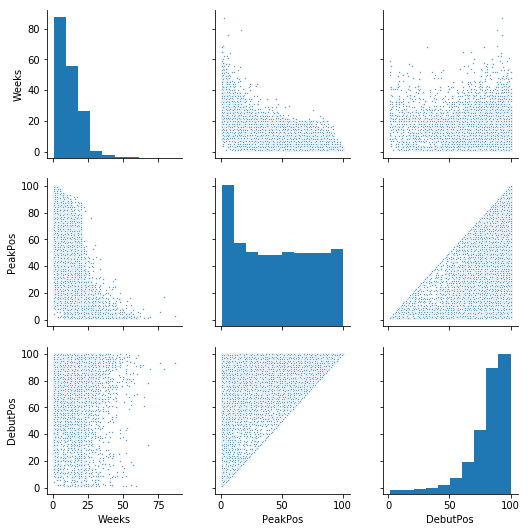

In [32]:
#Create pairplot
sns.pairplot(combined,plot_kws={'s': 3})

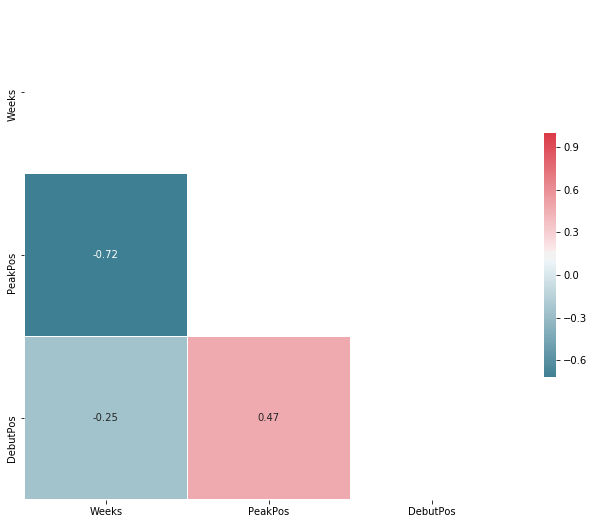

In [33]:
#Create correlation matrix
corr = combined.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
figure, axes = plt.subplots(figsize=(11, 9))

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5,cbar_kws={"shrink": .5},annot=True
           )

The pair plots and correlation matrix show a relatively strong negative correlation between peak position and total number of weeks.  This result is not very surprising, since songs that reach a higher peak are more popular and thus less likely to quickly fall out of favor on the radio, streaming and other media.  The positive correlation between peak position and debut position is actually misleading and not completely informative since debut position cannot be smaller than peak position. Between weeks and debut position, there is a negative correlation.  While this result does not agree with the trend we noticed in the songs with the most weeks on the Hot 100, it is still not too surprising.  Even though the extreme outliers began at a lower position and climbed through the ranks, it makes sense that songs that have a stronger initial debut have a longer lifetime on the chart. 

## Conclusion
As we have seen, there is a wealth of information that can be drawn from the Billboard Hot 100 song charts.  I hope you have enjoyed this notebook.  Any comments or suggestions are appreciated.